In [1]:
import lightgbm as lgb
import pandas as pd

In [2]:
# using the attribute information as the column names
train_file = "../model_data/branch_train.csv"
val_file = "../model_data/branch_val.csv"

branch_train_data = pd.read_csv(train_file)
branch_val_data = pd.read_csv(val_file)

print(branch_train_data.head())

                                      raw_string  loop_depth  number_BB  \
0     br i1 %11, label %12, label %17, !prof !36          -1         -1   
1      br i1 %9, label %10, label %11, !prof !36          -1         -1   
2                br i1 %46, label %47, label %55          -1         -1   
3    br i1 %77, label %78, label %103, !prof !37           1          9   
4                  br i1 %8, label %9, label %12          -1         -1   

   number_exits  number_exit_blocks  num_successors  isexit  isbackedge  \
0            -1                  -1              -1       0           0   
1            -1                  -1              -1       0           0   
2            -1                  -1              -1       0           0   
3             7                   7               2       1           0   
4            -1                  -1              -1       0           0   

   isdestinationinloop  isdestinationnestedloop  ...  operand_3.isfunctionarg  \
0                

In [3]:
branch_prob = 'branch_prob'
raw_string = 'raw_string'

clean_train_data = branch_train_data.loc[:, ~branch_train_data.columns.isin([branch_prob, raw_string])]
clean_train_labels = branch_train_data[branch_prob]

clean_val_data = branch_val_data.loc[:, ~branch_val_data.columns.isin([branch_prob, raw_string])]
clean_val_labels = branch_val_data[branch_prob]

train_dataset = lgb.Dataset(clean_train_data, clean_train_labels)
val_dataset = lgb.Dataset(clean_val_data, clean_val_labels)

clean_train_data.head()

,loop_depth,number_BB,number_exits,number_exit_blocks,num_successors,isexit,isbackedge,isdestinationinloop,isdestinationnestedloop,opcode_condition,...,operand_3.constant,operand_3.isfunctionarg,operand_3.isglobalvar,operand_3.isgeneralvar,operand_3.other,operand_4.constant,operand_4.isfunctionarg,operand_4.isglobalvar,operand_4.isgeneralvar,operand_4.other
0,-1,-1,-1,-1,-1,0,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0
1,-1,-1,-1,-1,-1,0,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0
2,-1,-1,-1,-1,-1,0,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0
3,1,9,7,7,2,1,0,1,0,53,...,0,0,0,0,0,0,0,0,0,0
4,-1,-1,-1,-1,-1,0,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


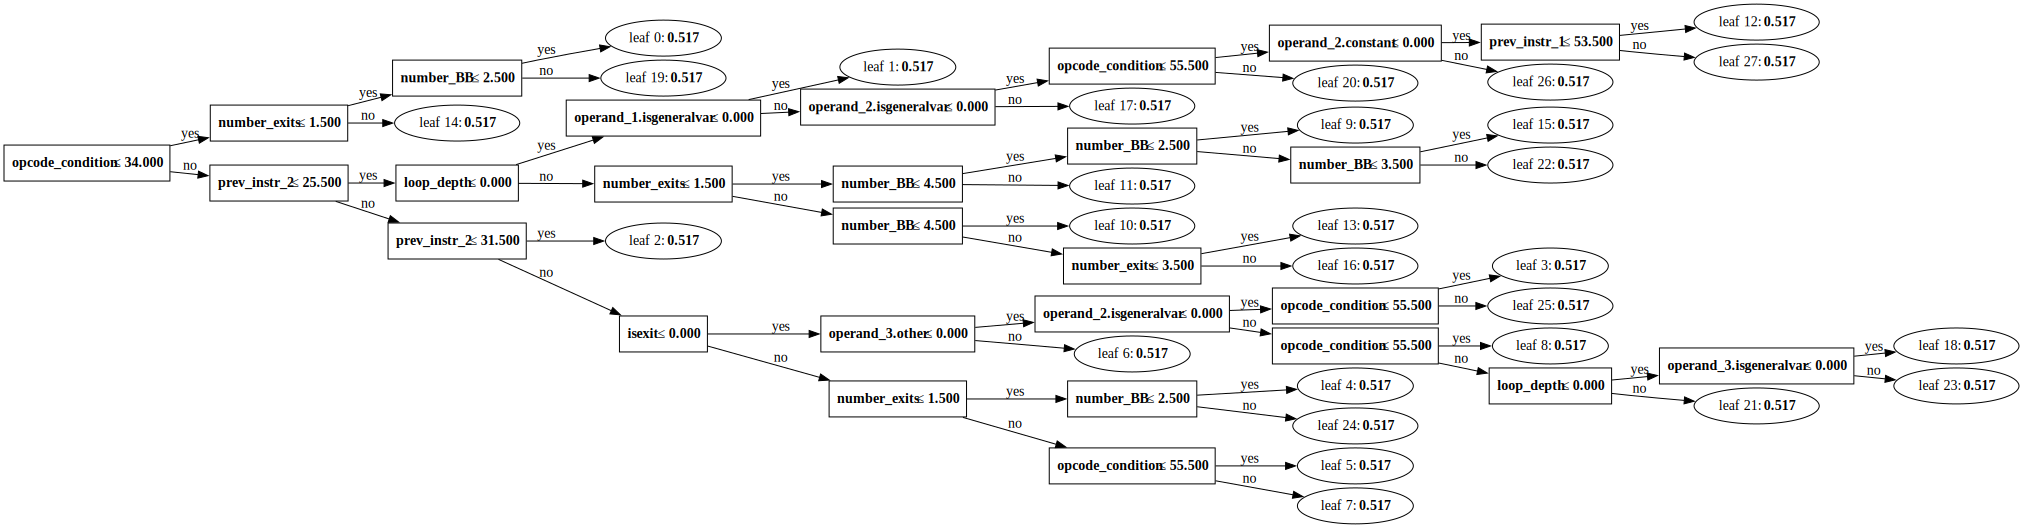

In [4]:
train_params = {
        'objective': 'regression',
        'num_iterations': 10000,
        'learning_rate': 0.001,
        'metric': "l2", # L2 Loss
        'verbose': -1
    }

model = lgb.train(train_params, train_set=train_dataset, valid_sets=val_dataset)

lgb.create_tree_digraph(model)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#print(model.predict(clean_val_data))

print(f"RMSE for Validation Set: {mean_squared_error(clean_val_labels.tolist(), model.predict(clean_val_data), squared=False)}") #RMSE
print(f"MAE for Validation Set: {mean_absolute_error(clean_val_labels.tolist(), model.predict(clean_val_data))}")

RMSE for Validation Set: 0.33914711057765357
MAE for Validation Set: 0.26038829966856214


In [6]:
test_file = "../model_data/branch_test.csv"
branch_test_data = pd.read_csv(test_file)

clean_test_data = branch_test_data.loc[:, ~branch_test_data.columns.isin([branch_prob, raw_string])]
clean_test_labels = branch_test_data[branch_prob]

test_predictions = model.predict(clean_test_data)

print(f"RMSE for Test Set: {mean_squared_error(clean_test_labels.tolist(), test_predictions, squared=False)}") #RMSE
print(f"MAE for Test Set: {mean_absolute_error(clean_test_labels.tolist(), test_predictions)}")

RMSE for Test Set: 0.33003693641742493
MAE for Test Set: 0.2596083544818685


In [7]:
model.save_model("lightgbm_branch_model.txt")

In [8]:
predictions_file = "lightgbm_test_predictions.csv"

test_predictions = pd.Series(test_predictions)

test_predictions.to_csv(predictions_file, index=False, header=False)